In [1]:
import numpy as np
import glob, os, re, sys
from pathlib import Path
sys.path.append('../')

import pandas as pd
import polars as pl
from scipy.stats import binned_statistic

import astro_helper as ah
import configparser
config = configparser.ConfigParser()
config.read('../config_allgas.ini')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from matplotlib import rc
rc('axes', linewidth=1.5)
rc('axes', edgecolor='#3C3C3C')
plt.style.use('mpl_style_Jeffreson.mplstyle')
custom_colors = {
    'grey': '#3C3C3C',
    'turquoise': '#5E9F87'
}

In [2]:
tags = ['ETG-vlM', 'ETG-lowM', 'ETG-medM', 'ETG-hiM', 'MW']
tagdirs = [Path(config[tag]['SAVE_DIR']) / Path(config[tag]['SUBDIR']) for tag in tags]
xymaxs = [config[tag].getfloat('XYMAX') for tag in tags] # kpc
xybinwidths = [config[tag].getfloat('XYBINWIDTH') for tag in tags] # pc
xybinnos = [int(np.rint(2.*xymax * ah.kpc_to_cm / (xybinwidth * ah.pc_to_cm))) for xymax, xybinwidth in zip(xymaxs, xybinwidths)]

# real weight

In [3]:
df = pl.read_parquet('/n/holystore01/LABS/itc_lab/Users/sjeffreson/GalactISM/GalactISM.parquet').to_pandas()

In [4]:
# separate by galaxy
weights_gal, Ptots_gal, Rs_gal = [], [], []
for tag, xymax in zip(tags, xymaxs):
    mask = df['galaxy'] == tag
    Ptot = np.array(df.loc[mask, 'Pturb']) + np.array(df.loc[mask, 'Ptherm'])
    Pturb = np.array(df.loc[mask, 'Pturb'])
    Ptot[Pturb <= 0.] = 0.
    Ptot = pd.Series(Ptot, index=df.loc[mask].index)
    Ptots_gal.append(Ptot)
    weights_gal.append(df.loc[mask, 'weight'])
    Rs_gal.append(df.loc[mask, 'R/Router'] * xymax)

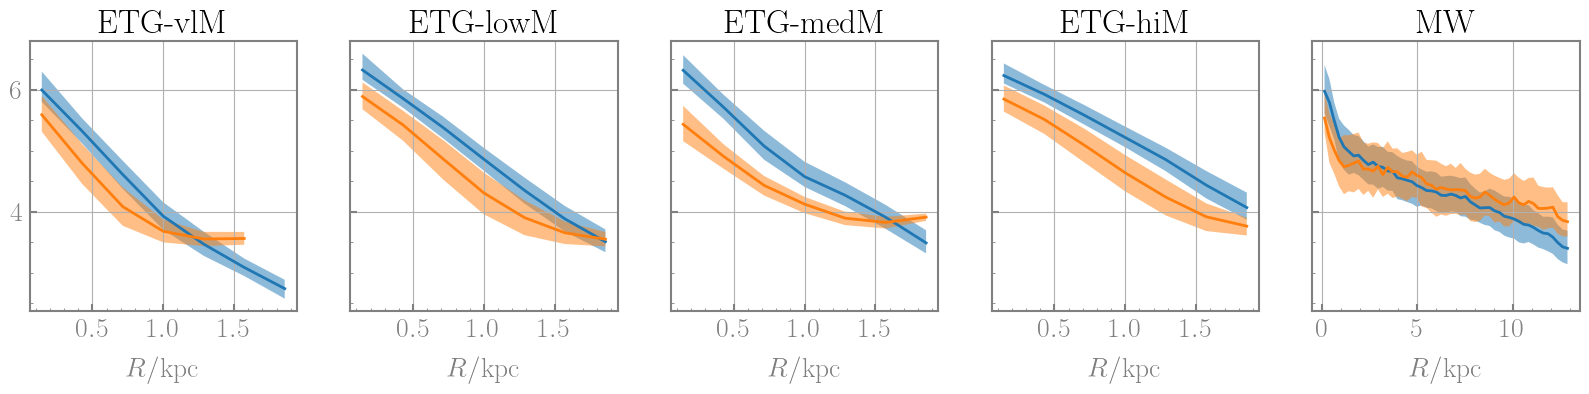

In [5]:
# plot the median weight as a function of R on a separate axis for each galaxy
fig, axs = plt.subplots(1, len(tags), figsize=(4*len(tags), 3.5), sharey=True)
for ax, tag, weights, Ptots, Rs, xymax in zip(axs, tags, weights_gal, Ptots_gal, Rs_gal, xymaxs):
    bins = np.linspace(0., xymax, int(np.rint(xymax/0.25)))
    Rbins = 0.5*(bins[:-1] + bins[1:])

    # weights (assuming symmetry)
    cnd = weights > 0.
    weights_med, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic='median')
    weights_q1, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    weights_q4, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    ax.plot(Rbins, np.log10(weights_med), lw=2)
    ax.fill_between(Rbins, np.log10(weights_q1), np.log10(weights_q4), alpha=0.5)

    # total pressures
    cnd = Ptots_gal[tags.index(tag)] > 0.
    Ptots_med, _, _ = binned_statistic(Rs[cnd], Ptots[cnd], bins=bins, statistic='median')
    Ptots_q1, _, _ = binned_statistic(Rs[cnd], Ptots[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    Ptots_q4, _, _ = binned_statistic(Rs[cnd], Ptots[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    ax.plot(Rbins, np.log10(Ptots_med), lw=2)
    ax.fill_between(Rbins, np.log10(Ptots_q1), np.log10(Ptots_q4), alpha=0.5)

    ax.set_xlabel(r'$R/{\rm kpc}$')
    ax.set_title(tag)
    ax.tick_params(axis='both', direction='in', which='both')
    ax.minorticks_on()
    ax.grid(True)
plt.show()

# geometric fitting weight

In [10]:
# print df columns
print(df.columns)

Index(['galaxy', 'weight', 'rotcurve', 'kappa', 'gas_surfdens',
       'gas_surfdens_cw', 'star_surfdens', 'SFR_surfdens', 'dm_voldens',
       'gas_voldens', 'star_voldens', 'H2_mass', 'HI_mass', 'H2HI_mass',
       'gas_voldens_midplane', 'gas_voldens_midplane_cw',
       'star_voldens_midplane', 'veldisp_midplane', 'Pturb', 'Ptherm',
       'R/Router', '__index_level_0__'],
      dtype='object')


In [17]:
# separate by galaxy
gasweights_gal, diskweights_gal, bulgeweights_gal, dmweights_gal = [], [], [], []
for tag, xymax in zip(tags, xymaxs):
    mask = df['galaxy'] == tag
    SigmaGas = df.loc[mask, 'gas_surfdens']
    SigmaStars = df.loc[mask, 'star_surfdens']
    rhoGas_mp = df.loc[mask, 'gas_voldens_midplane']
    rhoStars_mp = df.loc[mask, 'star_voldens_midplane']
    Hg = SigmaGas / 2. / rhoGas_mp
    Hs = SigmaStars / 2. / rhoStars_mp

    vcs = df.loc[mask, 'rotcurve']
    Rs = df.loc[mask, 'R/Router'] * xymax
    rhodms = df.loc[mask, 'dm_voldens']
    rhostars = df.loc[mask, 'star_voldens']
    Omegas2 = vcs**2/(Rs*ah.kpc_to_cm)**2#4. * np.pi * ah.G_cgs * rhodms
    Omegastars2 = vcs**2/(Rs*ah.kpc_to_cm)**2#4. * np.pi * ah.G_cgs * rhostars

    # gas component
    gasweights = np.pi * ah.G_cgs * SigmaGas**2 / 2.
    gasweights_gal.append(gasweights / ah.kB_cgs)

    # stellar disk component
    diskweights = np.pi * ah.G_cgs * SigmaGas * SigmaStars * Hg / (Hg + Hs)
    diskweights_gal.append(diskweights / ah.kB_cgs)

    # stellar bulge component
    bulgeweights = 4. * np.pi * ah.G_cgs * rhostars / 3. * SigmaGas * Hg / 3.
    bulgeweights_gal.append(bulgeweights / ah.kB_cgs)

    # dark matter component
    dmweights = 4. * np.pi * ah.G_cgs * rhodms * SigmaGas * Hg / 3.
    dmweights_gal.append(dmweights / ah.kB_cgs)

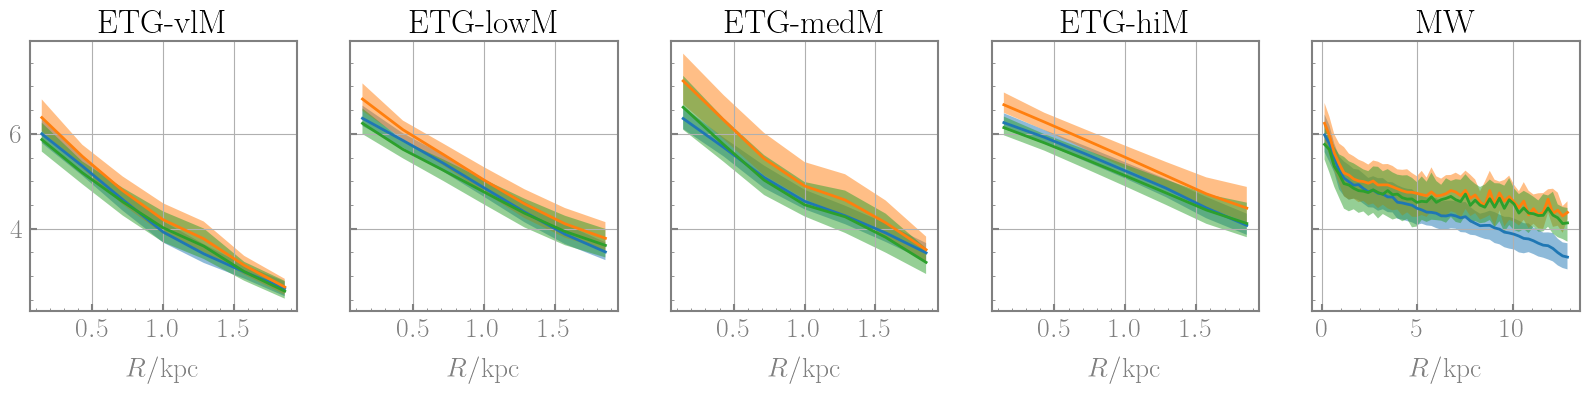

In [25]:
# plot the median weight as a function of R on a separate axis for each galaxy
fig, axs = plt.subplots(1, len(tags), figsize=(4*len(tags), 3.5), sharey=True)
for ax, tag, weights, gasweights, diskweights, bulgeweights, dmweights, Rs, xymax in zip(axs, tags, weights_gal, gasweights_gal, diskweights_gal, bulgeweights_gal, dmweights_gal, Rs_gal, xymaxs):
    bins = np.linspace(0., xymax, int(np.rint(xymax/0.25)))
    Rbins = 0.5*(bins[:-1] + bins[1:])

    # weights (assuming symmetry)
    cnd = weights > 0.
    weights_med, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic='median')
    weights_q1, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    weights_q4, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    ax.plot(Rbins, np.log10(weights_med), lw=2)
    ax.fill_between(Rbins, np.log10(weights_q1), np.log10(weights_q4), alpha=0.5)

    # geometric (gas) weight + disk weight
    cnd = (gasweights > 0.) & (diskweights > 0.) & (dmweights > 0.)
    gasweights_med, _, _ = binned_statistic(Rs[cnd], gasweights[cnd] + diskweights[cnd] + dmweights[cnd], bins=bins, statistic='median')
    gasweights_q1, _, _ = binned_statistic(Rs[cnd], gasweights[cnd] + diskweights[cnd] + dmweights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    gasweights_q4, _, _ = binned_statistic(Rs[cnd], gasweights[cnd] + diskweights[cnd] + dmweights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    ax.plot(Rbins, np.log10(gasweights_med), lw=2)
    ax.fill_between(Rbins, np.log10(gasweights_q1), np.log10(gasweights_q4), alpha=0.5)

    # geometric (gas) weight + bulge weight
    cnd = (gasweights > 0.) & (bulgeweights > 0.) & (dmweights > 0.)
    gasweights_med, _, _ = binned_statistic(Rs[cnd], gasweights[cnd] + bulgeweights[cnd] + dmweights[cnd], bins=bins, statistic='median')
    gasweights_q1, _, _ = binned_statistic(Rs[cnd], gasweights[cnd] + bulgeweights[cnd] + dmweights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    gasweights_q4, _, _ = binned_statistic(Rs[cnd], gasweights[cnd] + bulgeweights[cnd] + dmweights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    ax.plot(Rbins, np.log10(gasweights_med), lw=2)
    ax.fill_between(Rbins, np.log10(gasweights_q1), np.log10(gasweights_q4), alpha=0.5)

    ax.set_xlabel(r'$R/{\rm kpc}$')
    ax.set_title(tag)
    ax.tick_params(axis='both', direction='in', which='both')
    ax.minorticks_on()
    ax.grid(True)
plt.show()

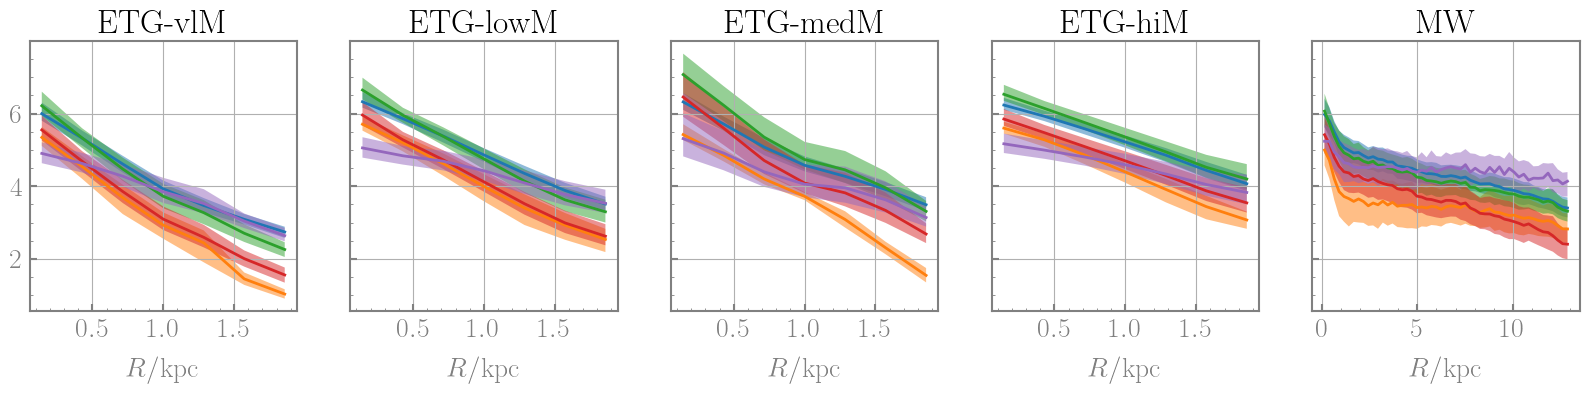

In [23]:
# plot the median weight as a function of R on a separate axis for each galaxy
fig, axs = plt.subplots(1, len(tags), figsize=(4*len(tags), 3.5), sharey=True)
for ax, tag, weights, gasweights, diskweights, bulgeweights, dmweights, Rs, xymax in zip(axs, tags, weights_gal, gasweights_gal, diskweights_gal, bulgeweights_gal, dmweights_gal, Rs_gal, xymaxs):
    bins = np.linspace(0., xymax, int(np.rint(xymax/0.25)))
    Rbins = 0.5*(bins[:-1] + bins[1:])

    # weights (assuming symmetry)
    cnd = weights > 0.
    weights_med, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic='median')
    weights_q1, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    weights_q4, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    ax.plot(Rbins, np.log10(weights_med), lw=2)
    ax.fill_between(Rbins, np.log10(weights_q1), np.log10(weights_q4), alpha=0.5)

    # geometric (gas) weight
    cnd = gasweights > 0.
    gasweights_med, _, _ = binned_statistic(Rs[cnd], gasweights[cnd], bins=bins, statistic='median')
    gasweights_q1, _, _ = binned_statistic(Rs[cnd], gasweights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    gasweights_q4, _, _ = binned_statistic(Rs[cnd], gasweights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    ax.plot(Rbins, np.log10(gasweights_med), lw=2)
    ax.fill_between(Rbins, np.log10(gasweights_q1), np.log10(gasweights_q4), alpha=0.5)

    # geometric (disk) weight
    cnd = diskweights > 0.
    diskweights_med, _, _ = binned_statistic(Rs[cnd], diskweights[cnd], bins=bins, statistic='median')
    diskweights_q1, _, _ = binned_statistic(Rs[cnd], diskweights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    diskweights_q4, _, _ = binned_statistic(Rs[cnd], diskweights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    ax.plot(Rbins, np.log10(diskweights_med), lw=2)
    ax.fill_between(Rbins, np.log10(diskweights_q1), np.log10(diskweights_q4), alpha=0.5)

    # geometric (bulge) weight
    cnd = bulgeweights > 0.
    bulgeweights_med, _, _ = binned_statistic(Rs[cnd], bulgeweights[cnd], bins=bins, statistic='median')
    bulgeweights_q1, _, _ = binned_statistic(Rs[cnd], bulgeweights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    bulgeweights_q4, _, _ = binned_statistic(Rs[cnd], bulgeweights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    ax.plot(Rbins, np.log10(bulgeweights_med), lw=2)
    ax.fill_between(Rbins, np.log10(bulgeweights_q1), np.log10(bulgeweights_q4), alpha=0.5)

    # geometric (dm) weight
    cnd = dmweights > 0.
    dmweights_med, _, _ = binned_statistic(Rs[cnd], dmweights[cnd], bins=bins, statistic='median')
    dmweights_q1, _, _ = binned_statistic(Rs[cnd], dmweights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    dmweights_q4, _, _ = binned_statistic(Rs[cnd], dmweights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    ax.plot(Rbins, np.log10(dmweights_med), lw=2)
    ax.fill_between(Rbins, np.log10(dmweights_q1), np.log10(dmweights_q4), alpha=0.5)

    ax.set_xlabel(r'$R/{\rm kpc}$')
    ax.set_title(tag)
    ax.tick_params(axis='both', direction='in', which='both')
    ax.minorticks_on()
    ax.grid(True)
plt.show()

# geometric fitting weight, resolved properties in cosmological simulations

In [27]:
# separate by galaxy
weights_geom_gal, weights_bulgegeom_gal, sigmaEffs_geom_gal, sigmaEffs_bulgegeom_gal = [], [], [], []
for tag, xymax in zip(tags, xymaxs):
    mask = df['galaxy'] == tag
    SigmaGas = df.loc[mask, 'gas_surfdens']
    SigmaStars = df.loc[mask, 'star_surfdens']
    vcs = df.loc[mask, 'rotcurve']
    Rs = df.loc[mask, 'R/Router'] * xymax
    rhodms = df.loc[mask, 'dm_voldens']
    rhostars = df.loc[mask, 'star_voldens']
    Omegas2 = vcs**2/(Rs*ah.kpc_to_cm)**2#4. * np.pi * ah.G_cgs * rhodms
    Omegastars2 = vcs**2/(Rs*ah.kpc_to_cm)**2#4. * np.pi * ah.G_cgs * rhostars

    # disk geometry (weight dominated by disk, sets scale-height)
    i = 0
    sigmaEffs = 12.e5*np.ones(len(Rs)) # initialize, cm/s
    while i < 10:
        i += 1
        Sigma_sg = SigmaGas + SigmaStars
        weights_geom = SigmaGas / 4. * (
            np.pi * ah.G_cgs * Sigma_sg
            + np.sqrt((np.pi * ah.G_cgs * Sigma_sg)**2 + 8./3. * Omegas2 * sigmaEffs**2)
        )/ah.kB_cgs
        sigmaEffs = 12.e5 * (weights_geom/1.e4)**0.22

    weights_geom_gal.append(weights_geom)
    sigmaEffs_geom_gal.append(sigmaEffs)

    # bulge geometry (weight dominated by bulge, sets scale-height)
    i = 0
    sigmaEffs_bulgegeom = 12.e5*np.ones(len(Rs)) # initialize, cm/s
    while i < 10:
        i += 1
        weights_bulgegeom = (
            np.pi * ah.G_cgs * SigmaGas**2 / 2.
            + np.sqrt(1./6.) * SigmaGas * sigmaEffs_bulgegeom * np.sqrt(Omegastars2/3. + Omegas2)
        )/ah.kB_cgs
        sigmaEffs_bulgegeom = 12.e5 * (weights_bulgegeom/1.e4)**0.22

    weights_bulgegeom_gal.append(weights_bulgegeom)
    sigmaEffs_bulgegeom_gal.append(sigmaEffs_bulgegeom)

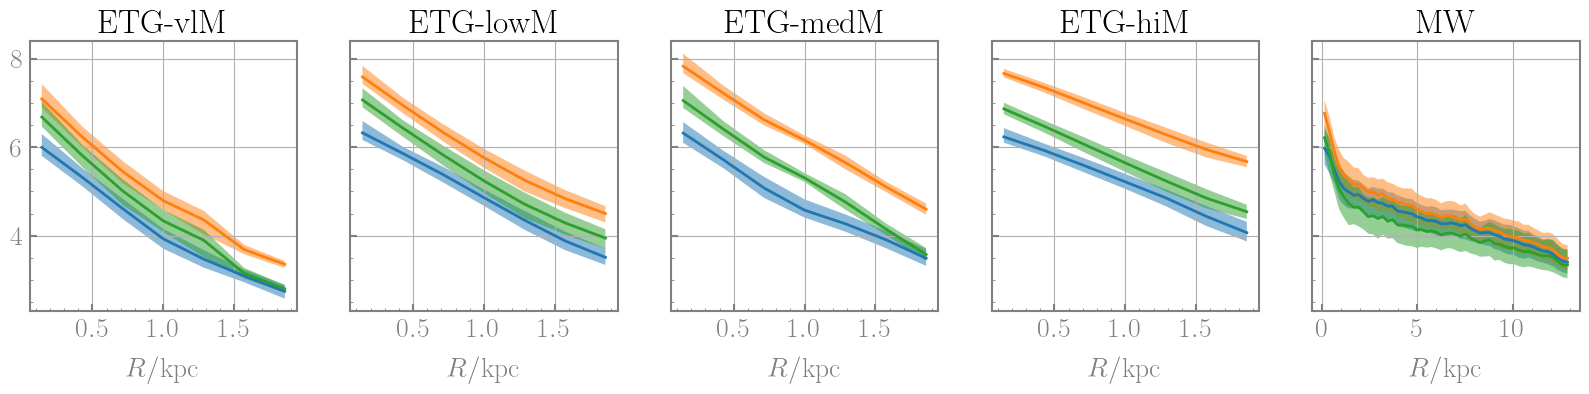

In [28]:
# plot the median weight as a function of R on a separate axis for each galaxy
fig, axs = plt.subplots(1, len(tags), figsize=(4*len(tags), 3.5), sharey=True)
for ax, tag, weights, weights_geom, weights_bulgegeom, Rs, xymax in zip(
    axs, tags, weights_gal, weights_geom_gal, weights_bulgegeom_gal, Rs_gal, xymaxs):
    bins = np.linspace(0., xymax, int(np.rint(xymax/0.25)))
    Rbins = 0.5*(bins[:-1] + bins[1:])
    cnd = weights > 0.
    weights_med, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic='median')
    weights_q1, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    weights_q4, _, _ = binned_statistic(Rs[cnd], weights[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    weights_geom_med_, _, _ = binned_statistic(Rs[cnd], weights_geom[cnd], bins=bins, statistic='median')
    weights_geom_q1_, _, _ = binned_statistic(Rs[cnd], weights_geom[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    weights_geom_q4_, _, _ = binned_statistic(Rs[cnd], weights_geom[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    weights_bulgegeom_med_, _, _ = binned_statistic(Rs[cnd], weights_bulgegeom[cnd], bins=bins, statistic='median')
    weights_bulgegeom_q1_, _, _ = binned_statistic(Rs[cnd], weights_bulgegeom[cnd], bins=bins, statistic=lambda x: np.percentile(x, 25))
    weights_bulgegeom_q4_, _, _ = binned_statistic(Rs[cnd], weights_bulgegeom[cnd], bins=bins, statistic=lambda x: np.percentile(x, 75))
    
    ax.plot(Rbins, np.log10(weights_med), lw=2)
    ax.fill_between(Rbins, np.log10(weights_q1), np.log10(weights_q4), alpha=0.5)

    ax.plot(Rbins, np.log10(weights_geom_med_), lw=2)
    ax.fill_between(Rbins, np.log10(weights_geom_q1_), np.log10(weights_geom_q4_), alpha=0.5)

    ax.plot(Rbins, np.log10(weights_bulgegeom_med_), lw=2)
    ax.fill_between(Rbins, np.log10(weights_bulgegeom_q1_), np.log10(weights_bulgegeom_q4_), alpha=0.5)

    ax.set_xlabel(r'$R/{\rm kpc}$')
    ax.set_title(tag)
    ax.tick_params(axis='both', direction='in', which='both')
    ax.minorticks_on()
    ax.grid(True)
plt.show()